In [5]:
# Importing substantial libraries
import os

%matplotlib inline

import torch
import torch.nn as nn
import numpy as np

import random
import matplotlib.pyplot as plt
import pandas as pd
from config import get_cfg_defaults

from kale.utils.download import download_file_by_url
from kale.loaddata.image_access import read_dicom_images
from kale.interpret import visualize
from kale.embed.mpca import MPCA

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.lines as mlines
import scipy.integrate as integrate

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
#from kale.pipeline.mpca_trainer import MPCATrainer
from sklearn.calibration import CalibratedClassifierCV

In [6]:
# =============================================================================
# Author: Shuo Zhou, szhou20@sheffield.ac.uk
#         Haiping Lu, h.lu@sheffield.ac.uk or hplu@ieee.org
# =============================================================================

"""Implementation of MPCA->Feature Selection->Linear SVM/LogisticRegression Pipeline

References:
    [1] Swift, A. J., Lu, H., Uthoff, J., Garg, P., Cogliano, M., Taylor, J., ... & Kiely, D. G. (2020). A machine
    learning cardiac magnetic resonance approach to extract disease features and automate pulmonary arterial
    hypertension diagnosis. European Heart Journal-Cardiovascular Imaging.
    [2] Song, X., Meng, L., Shi, Q., & Lu, H. (2015, October). Learning tensor-based features for whole-brain fMRI
    classification. In International Conference on Medical Image Computing and Computer-Assisted Intervention
    (pp. 613-620). Springer, Cham.
    [3] Lu, H., Plataniotis, K. N., & Venetsanopoulos, A. N. (2008). MPCA: Multilinear principal component analysis of
    tensor objects. IEEE Transactions on Neural Networks, 19(1), 18-39.
"""

import logging

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.utils.validation import check_is_fitted



param_c_grids = list(np.logspace(-4, 2, 7))
classifiers = {
    "svc": [SVC, {"kernel": ["linear"], "C": param_c_grids}],
    "linear_svc": [LinearSVC, {"C": param_c_grids}],
    "lr": [LogisticRegression, {"C": param_c_grids}],
}

# k-fold cross validation used for grid search, i.e. searching for optimal value of C
default_search_params = {"cv": 5}
default_mpca_params = {"var_ratio": 0.97, "return_vector": True}


class MPCATrainer(BaseEstimator, ClassifierMixin):
    def __init__(
        self, classifier="svc", classifier_params="auto", mpca_params=None, n_features=None, search_params=None
    ):
        """Trainer of pipeline: MPCA->Feature selection->Classifier

        Args:
            classifier (str, optional): Available classifier options: {"svc", "linear_svc", "lr"}, where "svc" trains a
                support vector classifier, supports both linear and non-linear kernels, optimizes with library "libsvm";
                "linear_svc" trains a support vector classifier with linear kernel only, and optimizes with library
                "liblinear", which suppose to be faster and better in handling large number of samples; and "lr" trains
                a classifier with logistic regression. Defaults to "svc".
            classifier_params (dict, optional): Parameters of classifier. Defaults to 'auto'.
            mpca_params (dict, optional): Parameters of MPCA. Defaults to None.
            n_features (int, optional): Number of features for feature selection. Defaults to None, i.e. all features
                after dimension reduction will be used.
            search_params (dict, optional): Parameters of grid search. Defaults to None.

        """
        if classifier not in ["svc", "linear_svc", "lr"]:
            error_msg = "Valid classifier should be 'svc', 'linear_svc', or 'lr', but given %s" % classifier
            logging.error(error_msg)
            raise ValueError(error_msg)

        self.classifier = classifier
        # init mpca object
        if mpca_params is None:
            self.mpca_params = default_mpca_params
        else:
            self.mpca_params = mpca_params
        self.mpca = MPCA(**self.mpca_params)
        # init feature selection parameters
        self.n_features = n_features
        self.feature_order = None
        # init classifier object
        if search_params is None:
            self.search_params = default_search_params
        else:
            self.search_params = search_params

        self.auto_classifier_param = False
        if classifier_params == "auto":
            self.auto_classifier_param = True
            clf_param_grid = classifiers[classifier][1]
            self.grid_search = GridSearchCV(
                classifiers[classifier][0](), param_grid=clf_param_grid, **self.search_params
            )
            self.clf = None
        elif isinstance(classifier_params, dict):
            self.clf = classifiers[classifier][0](**classifier_params)
        else:
            error_msg = "Invalid classifier parameter type"
            logging.error(error_msg)
            raise ValueError(error_msg)

        self.classifier_params = classifier_params

    def fit(self, x, y):
        """Fit a pipeline with the given data x and labels y

        Args:
            x (array-like tensor): input data, shape (n_samples, I_1, I_2, ..., I_N)
            y (array-like): data labels, shape (n_samples, )

        Returns:
            self
        """
        # fit mpca
        self.mpca.fit(x)
        self.mpca.set_params(**{"return_vector": True})
        self.x_transformed = self.mpca.transform(x)

        # feature selection
        if self.n_features is None:
            self.n_features = self.x_transformed.shape[1]
            self.feature_order = self.mpca.idx_order
        else:
            f_score, p_val = f_classif(self.x_transformed, y)
            self.feature_order = (-1 * f_score).argsort()
        self.x_transformed = self.x_transformed[:, self.feature_order][:, : self.n_features]

        # fit classifier
        if self.auto_classifier_param:
            self.grid_search.param_grid["C"].append(1 / x.shape[0])
            self.grid_search.fit(self.x_transformed, y)
            self.clf = self.grid_search.best_estimator_
        if self.classifier == "svc":
            self.clf.set_params(**{"probability": True})

        self.clf.fit(self.x_transformed, y)

    def predict(self, x):
        """Predict the labels for the given data x

        Args:
            x (array-like tensor): input data, shape (n_samples, I_1, I_2, ..., I_N)

        Returns:
            array-like: Predicted labels, shape (n_samples, )
        """
        return self.clf.predict(self._extract_feature(x))

    def decision_function(self, x):
        """Decision scores of each class for the given data x

        Args:
            x (array-like tensor): input data, shape (n_samples, I_1, I_2, ..., I_N)

        Returns:
            array-like: decision scores, shape (n_samples,) for binary case, else (n_samples, n_class)
        """
        return self.clf.decision_function(self._extract_feature(x))

    def predict_proba(self, x):
        """Probability of each class for the given data x. Not supported by "linear_svc".

        Args:
            x (array-like tensor): input data, shape (n_samples, I_1, I_2, ..., I_N)

        Returns:
            array-like: probabilities, shape (n_samples, n_class)
        """
        if self.classifier == "linear_svc":
            error_msg = "Linear SVC does not support computing probability."
            logging.error(error_msg)
            raise ValueError(error_msg)
        return self.clf.predict_proba(self._extract_feature(x))

    def _extract_feature(self, x):
        """Extracting features for the given data x with MPCA->Feature selection

        Args:
            x (array-like tensor): input data, shape (n_samples, I_1, I_2, ..., I_N)

        Returns:
            array-like: n_new, shape (n_samples, n_features)
        """
        check_is_fitted(self.clf)
        self.x_transformed = self.mpca.transform(x)

        return self.x_transformed[:, self.feature_order][:, : self.n_features]

In [10]:
cfg_path = "pykale/examples/cmri_mpca/configs/tutorial_svc.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  BASE_DIR: SA_64x64
  FILE_FORAMT: zip
  IMG_DIR: DICOM
  LANDMARK_FILE: landmarks_64x64.csv
  MASK_DIR: Mask
  ROOT: ../data
  SOURCE: https://github.com/pykale/data/raw/main/images/ShefPAH-179/SA_64x64.zip
IM_KWARGS:
  cmap: gray
MARKER_KWARGS:
  marker: o
  markeredgecolor: r
  markeredgewidth: 1.5
  markerfacecolor: (1, 1, 1, 0.1)
OUTPUT:
  ROOT: ./outputs
PIPELINE:
  CLASSIFIER: svc
PROC:
  SCALE: 2
WEIGHT_KWARGS:
  alpha: 0.7
  markersize: 6


In [11]:
base_dir = cfg.DATASET.BASE_DIR
file_format = cfg.DATASET.FILE_FORAMT
download_file_by_url(cfg.DATASET.SOURCE, cfg.DATASET.ROOT, "%s.%s" % (base_dir, file_format), file_format)

  0%|          | 0/24296488 [00:00<?, ?it/s]

Extracting /Users/matt/Desktop/Dissertation/src/Confidence Calibration/../data/SA_64x64.zip to /Users/matt/Desktop/Dissertation/src/Confidence Calibration/../data


In [12]:
img_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.IMG_DIR)
images = read_dicom_images(img_path, sort_instance=True, sort_patient=True)

mask_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.MASK_DIR)
mask = read_dicom_images(mask_path, sort_instance=True)

/opt/anaconda3/lib/python3.8/site-packages/pydicom/filereader.py:354: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(msg + f" - using {found_vr} VR for reading", UserWarning)


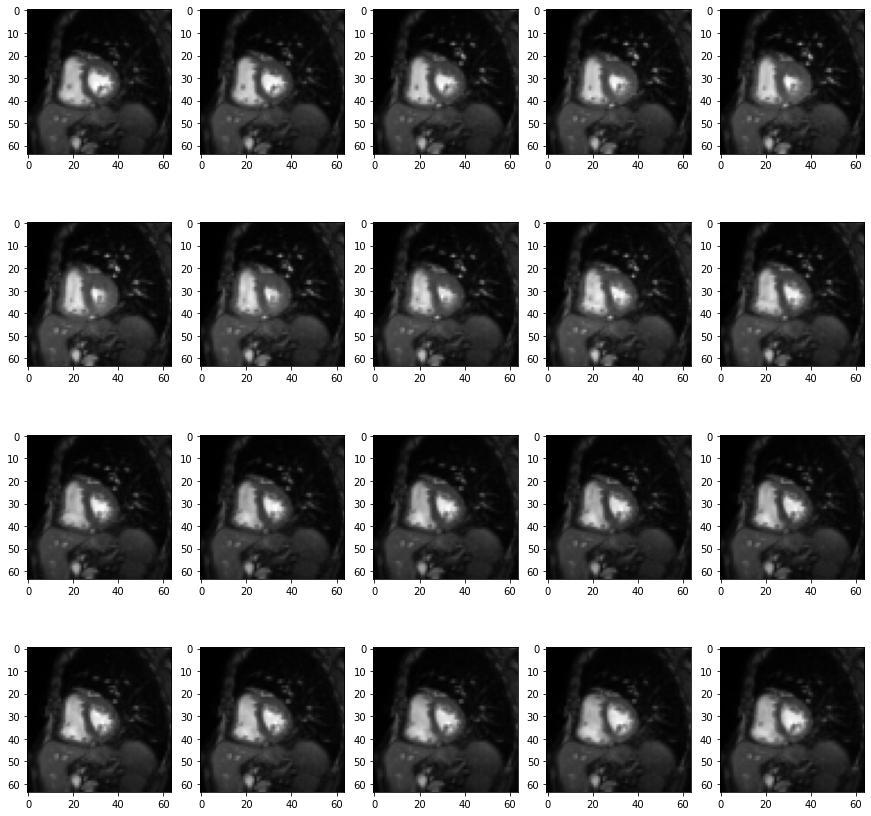

In [13]:
# Plotting all images from a random subject
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(images[i][j-1], cmap="gray")



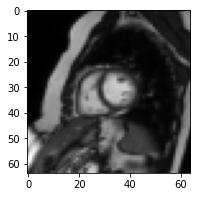

In [14]:
fig = plt.figure(figsize=(3,3))
plt.imshow(images[0][0], cmap='gray')
plt.savefig('image_org', format='jpg')

In [15]:
images.shape # (179, 20, 64, 64)

(179, 20, 64, 64)

In [16]:
landmark_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.LANDMARK_FILE)
landmark_df = pd.read_csv(landmark_path, index_col="Subject")  # read .csv file as dataframe
landmarks = landmark_df.iloc[:, :6].values
y = landmark_df["Group"].values
y[np.where(y != 0)] = 1 

<ipython-input-17-b779893f6a1b>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize.plot_multi_images(


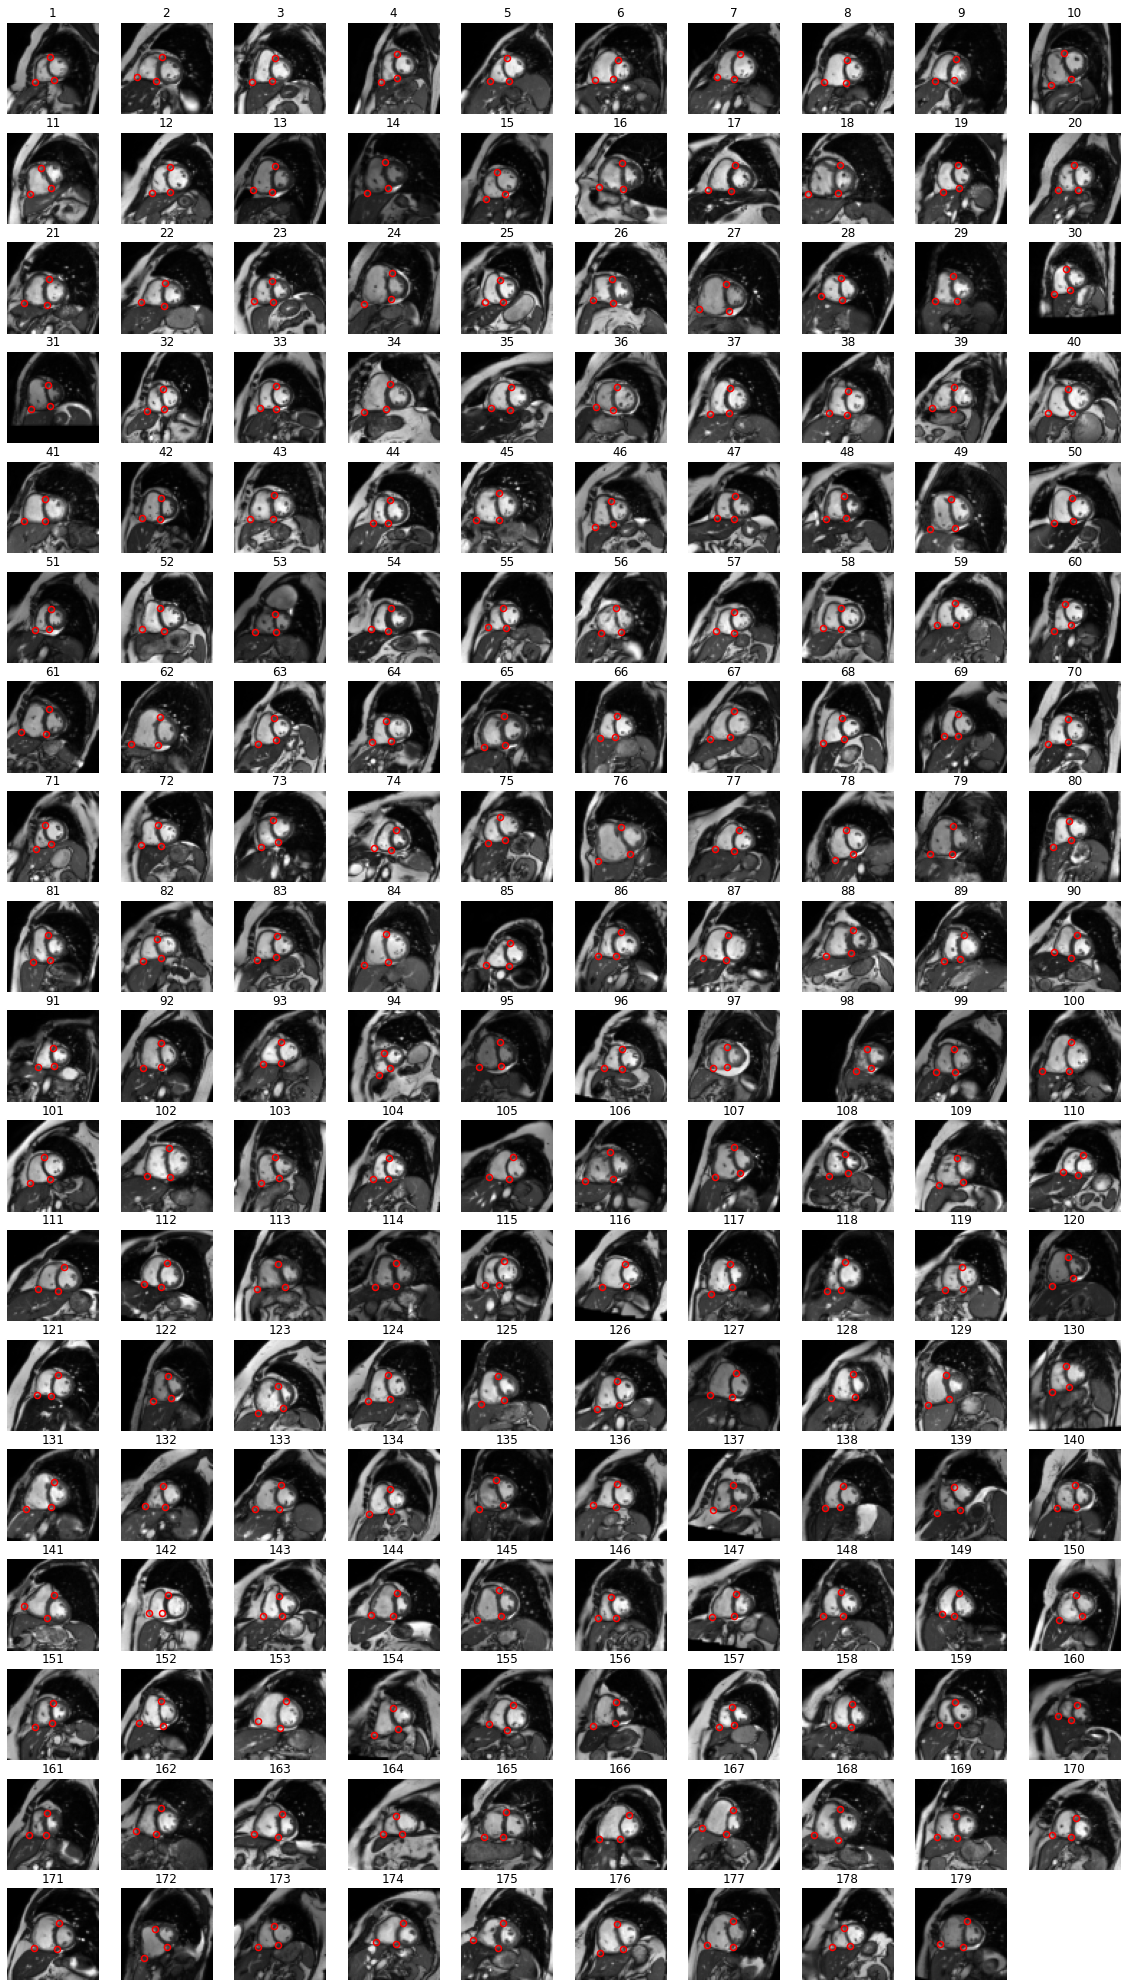

In [17]:
#visualisation with landmarks

visualize.plot_multi_images(
    images[:, 0, ...], marker_locs=landmarks, im_kwargs=dict(cfg.IM_KWARGS), marker_kwargs=dict(cfg.MARKER_KWARGS)
).show()

In [18]:
from kale.prepdata.image_transform import mask_img_stack, normalize_img_stack, reg_img_stack, rescale_img_stack

In [19]:
img_reg, max_dist = reg_img_stack(images.copy(), landmarks)

In [20]:
#Masking
img_masked = mask_img_stack(img_reg.copy(), mask[0, 0, ...])

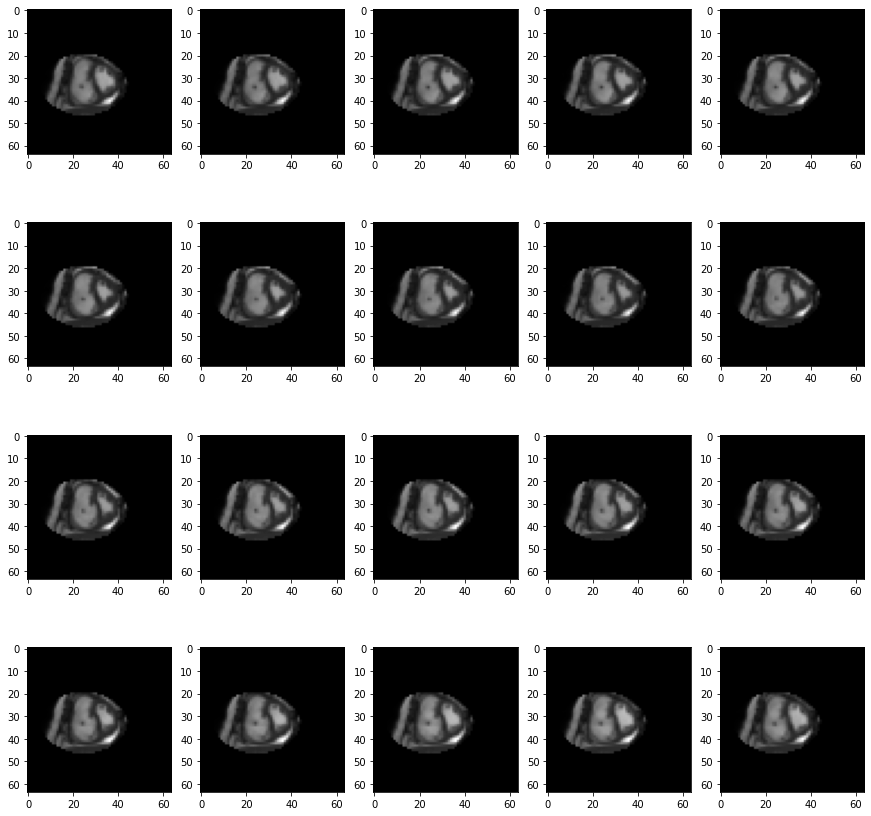

In [21]:
#Plotting masked images
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(img_masked[i][j-1], cmap="gray")

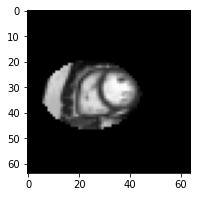

In [22]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img_masked[0][0], cmap='gray')
plt.savefig('image_masked', format='jpg')

In [23]:
img_rescaled = rescale_img_stack(img_masked.copy(), scale=1 / 2)

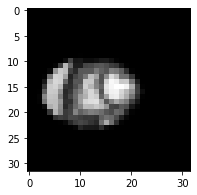

In [24]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img_rescaled[0][0], cmap='gray')
plt.savefig('image_rescaled', format='jpg')

In [25]:
img_rescaled.shape # (179, 20, 32, 32) -> rescaling would not be necessary for Deep Learning model

(179, 20, 32, 32)

In [26]:
img_norm = normalize_img_stack(img_rescaled.copy())

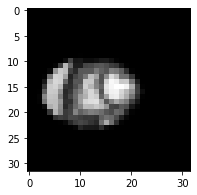

In [27]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img_norm[0][0], cmap='gray')
plt.savefig('image_norm', format='jpg')

In [28]:
img_norm.shape

(179, 20, 32, 32)

In [29]:
# Training

x = img_norm.copy() # creating copy to avoid modifying original images due to the pointer nature
trainer = MPCATrainer(classifier='svc', n_features=200)
cv_results = cross_validate(trainer, x, y, cv=10, scoring=["accuracy", "roc_auc"], n_jobs=1)

In [30]:
cv_results

{'fit_time': array([2.22507691, 0.64361501, 0.67247295, 0.66961002, 0.6682539 ,
        0.68099093, 0.70903778, 0.71104598, 0.72727776, 0.76470971]),
 'score_time': array([0.00404406, 0.00398111, 0.00405598, 0.00275803, 0.00282121,
        0.00269485, 0.00288916, 0.00299311, 0.00348592, 0.00406408]),
 'test_accuracy': array([0.77777778, 0.77777778, 0.83333333, 0.72222222, 0.83333333,
        0.72222222, 0.88888889, 0.61111111, 0.77777778, 0.82352941]),
 'test_roc_auc': array([0.81818182, 0.75324675, 0.95833333, 0.91666667, 0.90277778,
        0.77777778, 0.81944444, 0.76388889, 0.86111111, 0.71212121])}

In [31]:
print(f"Averaged test accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Averaged test area under ROC curve: {cv_results['test_roc_auc'].mean()}")

Averaged test accuracy: 0.7767973856209149
Averaged test area under ROC curve: 0.8283549783549784


In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve

In [33]:
z = img_norm
mpca = MPCA(var_ratio=0.97)

In [34]:
z_projected = mpca.fit_transform(z)

In [35]:
z_projected = mpca.transform(z)

In [36]:
z_projected.shape

(179, 3, 9, 14)

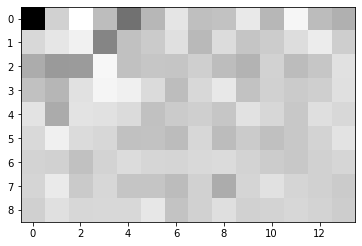

In [37]:
img_mpca = mpca.transform(z)
plt.imshow(img_mpca[0][0], cmap="gray")


In [38]:
clf = SVC(probability=True, gamma='auto')
clf.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [39]:
nsamples, nbatches, nx, ny = img_mpca.shape
img_mpca.shape

(179, 3, 9, 14)

In [40]:
d2_img_mpca = np.reshape(img_mpca, (nsamples, -1))
y.shape

(179,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(d2_img_mpca, y, test_size=0.2)
params = {'kernel': ('linear', 'rbf'), 'C':[1, 10, 20]}
grd = GridSearchCV(clf, params, scoring='roc_auc', cv=10)
grd.fit(X_train, y_train)

clf = SVC(probability=True, gamma='auto', kernel='linear', C=1)

In [42]:
pd.DataFrame(grd.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009232,0.000527,0.000650,0.000059,1,linear,"{'C': 1, 'kernel': 'linear'}",0.814815,1.000000,0.796296,0.911111,0.822222,0.755556,0.755556,0.688889,0.822222,0.854167,0.822083,0.082414,4
1,0.010002,0.000181,0.000816,0.000023,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.814815,0.888889,0.888889,1.000000,0.777778,1.000000,0.844444,0.888889,0.711111,0.770833,0.858565,0.089914,3
2,0.009095,0.000528,0.000690,0.000112,10,linear,"{'C': 10, 'kernel': 'linear'}",0.814815,1.000000,0.796296,0.911111,0.822222,0.755556,0.755556,0.688889,0.822222,0.854167,0.822083,0.082414,4
3,0.011017,0.000241,0.000856,0.000113,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.888889,1.000000,0.888889,1.000000,0.800000,0.777778,0.866667,0.866667,0.888889,0.833333,0.881111,0.069575,1
4,0.009019,0.000381,0.000630,0.000089,20,linear,"{'C': 20, 'kernel': 'linear'}",0.814815,1.000000,0.796296,0.911111,0.822222,0.755556,0.755556,0.688889,0.822222,0.854167,0.822083,0.082414,4
5,0.011145,0.000166,0.000785,0.000063,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.888889,1.000000,0.870370,1.000000,0.822222,0.688889,0.888889,0.888889,0.911111,0.833333,0.879259,0.084930,2


In [43]:
#cv_results = KFold(n_splits=10, shuffle=True, )
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

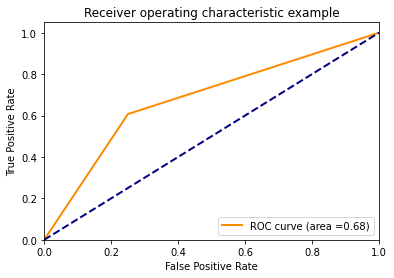

In [44]:

fpr, tpr, thresholds = roc_curve(y_test, y_hat, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area ={0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [45]:
# plotting calibration curve
y_probs = clf.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)

In [46]:
prob_pred

array([0.05222425, 0.26386507, 0.44653608, 0.54517578, 0.6537631 ,
       0.78905688, 0.85385315, 0.96017456])

In [47]:
prob_true

array([0.42857143, 0.5       , 1.        , 1.        , 1.        ,
       1.        , 0.66666667, 1.        ])

Text(0.5, 0.98, 'Calibration curve for SVC for cMRI classification')

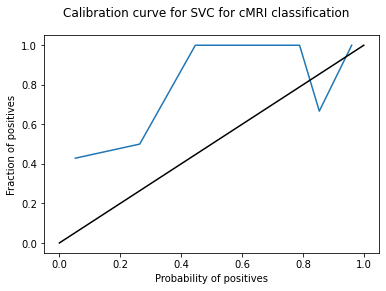

In [48]:
fig, ax = plt.subplots()
plt.plot(prob_pred, prob_true)
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
ax.set_xlabel("Probability of positives")
ax.set_ylabel("Fraction of positives")
fig.suptitle("Calibration curve for SVC for cMRI classification")

In [49]:
uncalibrated_report = classification_report(y_test, y_hat)
print(uncalibrated_report)

              precision    recall  f1-score   support

           0       0.35      0.75      0.48         8
           1       0.89      0.61      0.72        28

    accuracy                           0.64        36
   macro avg       0.62      0.68      0.60        36
weighted avg       0.77      0.64      0.67        36



In [50]:
brier_score_loss(y_test, y_probs)

0.1714986754004963

In [51]:
log_loss(y_test, y_probs)

0.5061496888652839

In [52]:
from sklearn.metrics import balanced_accuracy_score

In [53]:
balanced_accuracy_score(y_test, y_hat)

0.6785714285714286

In [54]:
# calibrating the classifier
from sklearn.calibration import CalibratedClassifierCV
clf = SVC(probability=True, gamma='auto', kernel='linear', C=1)

In [55]:
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=10, method="sigmoid")

In [56]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=1, gamma='auto', kernel='linear',
                                          probability=True),
                       cv=10)

In [57]:
X_train.shape

(143, 378)

In [58]:
y_hat_calb = calibrated_clf.predict(X_test)
y_probs_calb = calibrated_clf.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)

Text(0.5, 0.98, 'Calibration curve for Calibrated SVC for cMRI classification (Platt scaling method)')

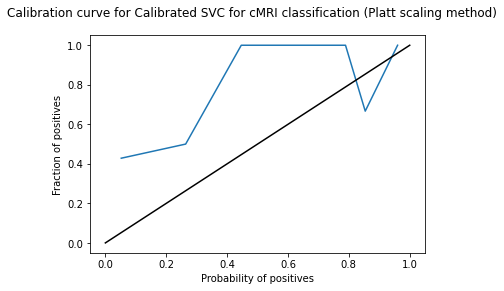

In [59]:
fig, ax = plt.subplots()
plt.plot(prob_pred, prob_true)
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
ax.set_xlabel("Probability of positives")
ax.set_ylabel("Fraction of positives")
fig.suptitle("Calibration curve for Calibrated SVC for cMRI classification (Platt scaling method)")

In [60]:
unique, counts = np.unique(y_train, return_counts=True)

In [61]:
counts[0]/(counts[0] + counts[1])

0.3776223776223776

In [62]:
calibrated_report = classification_report(y_test, y_hat_calb)
print(calibrated_report)

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.92      0.79      0.85        28

    accuracy                           0.78        36
   macro avg       0.71      0.77      0.72        36
weighted avg       0.82      0.78      0.79        36



In [63]:
brier_score_loss(y_test, y_probs_calb)

0.16877594288416606

In [64]:
log_loss(y_test, y_probs_calb)

0.5060112654541576

In [65]:
balanced_accuracy_score(y_test, y_hat_calb)

0.7678571428571428

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [67]:
trainer = MPCATrainer(classifier='svc', n_features=None)
trainer.fit(X_train, y_train)
#cv_results = cross_validate(trainer, x, y, cv=10, scoring=["accuracy", "roc_auc"], n_jobs=1)

In [68]:
#print(f"Averaged test accuracy: {cv_results['test_accuracy'].mean()}")
#print(f"Averaged test area under ROC curve: {cv_results['test_roc_auc'].mean()}")

In [69]:
y_probs = trainer.predict_proba(X_test)[:,1]

In [70]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)

Text(0.5, 0.98, 'Calibration curve for uncalibrated SVC for cMRI classification (MPCATrainer)')

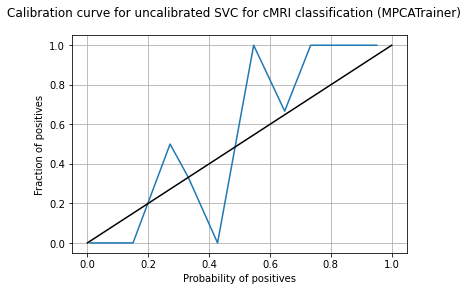

In [71]:
fig, ax = plt.subplots()
plt.plot(prob_pred, prob_true)
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
plt.grid()
ax.set_xlabel("Probability of positives")
ax.set_ylabel("Fraction of positives")
fig.suptitle("Calibration curve for uncalibrated SVC for cMRI classification (MPCATrainer)")

In [72]:
calibrated_trainer = MPCATrainer(classifier='svc', n_features=None)
calibrated_trainer.fit(X_train, y_train)
#cv_results = cross_validate(calibrated_trainer, X_train, y_train, cv=10, scoring=["accuracy", "roc_auc"], n_jobs=1)

y_probs = calibrated_trainer.predict_proba(X_test)[:, 1]

In [73]:
calibrated_trainer.x_transformed

array([[ 2.70530907e-01,  1.25133608e+00,  5.33285261e-01, ...,
        -9.68374211e-03, -9.82241400e-03,  9.41938571e-03],
       [ 1.93352049e+00, -5.47793729e+00, -2.77295454e+00, ...,
        -8.06338212e-03,  1.29860815e-02,  1.12860049e-02],
       [ 2.22627801e-01,  2.45843069e+00,  3.13247486e+00, ...,
        -3.34727658e-03,  1.06689009e-02,  1.96174732e-02],
       ...,
       [ 2.60234063e+00, -1.53496392e+00, -3.63568074e+00, ...,
        -1.39280513e-02, -5.12656947e-03, -2.98987482e-03],
       [ 1.10026930e+00,  2.38685201e+00,  1.09075561e+00, ...,
        -1.39336117e-02, -8.81028037e-03,  1.08921889e-02],
       [ 2.11820236e+00,  1.03792092e+00, -2.54989489e+00, ...,
         3.23675326e-02,  6.92402703e-03,  5.19901071e-03]])

In [74]:
cv_results

{'fit_time': array([2.22507691, 0.64361501, 0.67247295, 0.66961002, 0.6682539 ,
        0.68099093, 0.70903778, 0.71104598, 0.72727776, 0.76470971]),
 'score_time': array([0.00404406, 0.00398111, 0.00405598, 0.00275803, 0.00282121,
        0.00269485, 0.00288916, 0.00299311, 0.00348592, 0.00406408]),
 'test_accuracy': array([0.77777778, 0.77777778, 0.83333333, 0.72222222, 0.83333333,
        0.72222222, 0.88888889, 0.61111111, 0.77777778, 0.82352941]),
 'test_roc_auc': array([0.81818182, 0.75324675, 0.95833333, 0.91666667, 0.90277778,
        0.77777778, 0.81944444, 0.76388889, 0.86111111, 0.71212121])}

In [75]:
print(f"Averaged test accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Averaged test area under ROC curve: {cv_results['test_roc_auc'].mean()}")

Averaged test accuracy: 0.7767973856209149
Averaged test area under ROC curve: 0.8283549783549784


In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
class PlattScaling:
    
    def transform(self, y_probs, model, y_test):
        self.lr = LogisticRegression()
        self.lr.fit(model.x_transformed, y_test)
        print(self.lr.coef_.shape)
        output = np.multiply(y_probs, self.lr.coef_) + self.lr.intercept_
        output = 1/(1 + np.exp(output))
        
        return output
    
    def calibrate(self, model, y_probs, y_test):
        #self.coef = model.coef_[0]
        #self.intercept = model.intercept_
        y_probs_calibrated = self.transform(y_probs, model, y_test)
        
        return y_probs_calibrated
    
    def expected_error(self, prob_true, prob_pred, y_probs):
        ese = np.sum(abs(prob_true - prob_pred) * ((len(prob_true) + 1) / len(y_probs)))
        
        return ese
    
    def calibration(self, y_test, model, y_probs):
        y_probs_calibrated = self.transform(y_probs, model, y_test)
        prob_true, prob_pred = calibration_curve(y_test, y_probs_calibrated, n_bins=10, normalize=True)
        ese = self.expected_error(prob_true, prob_pred, y_probs)
        
        return prob_true, prob_pred, ese

In [78]:
platt = PlattScaling()

In [79]:
# Here starts the best calibration that I could implement.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, stratify=y_train, shuffle=True)

In [81]:
uncalibrated_trainer = MPCATrainer(classifier='svc', n_features=None)
calibrated_trainer = MPCATrainer(classifier='svc', n_features=None)

In [82]:
uncalibrated_trainer.fit(X_train, y_train)
calibrated_trainer.fit(X_train_sub, y_train_sub)

In [83]:
calibrated_trainer.clf = CalibratedClassifierCV(calibrated_trainer.clf, cv='prefit', method='sigmoid')
calibrated_trainer.fit(X_val, y_val)

In [84]:
y_probs_uncalb = uncalibrated_trainer.predict_proba(X_test)[:, 1]
y_probs_calb = calibrated_trainer.predict_proba(X_test)[:, 1]

In [85]:
prob_true_uncalb, prob_pred_uncalb = calibration_curve(y_test, y_probs_uncalb, n_bins=10, normalize=True)
prob_true_calb, prob_pred_calb = calibration_curve(y_test, y_probs_calb, n_bins=10, normalize=True)

In [86]:
ese_uncalb = platt.expected_error(prob_true_uncalb, prob_pred_uncalb, y_probs_uncalb)
ese_calb = platt.expected_error(prob_true_calb, prob_pred_calb, y_probs_calb)

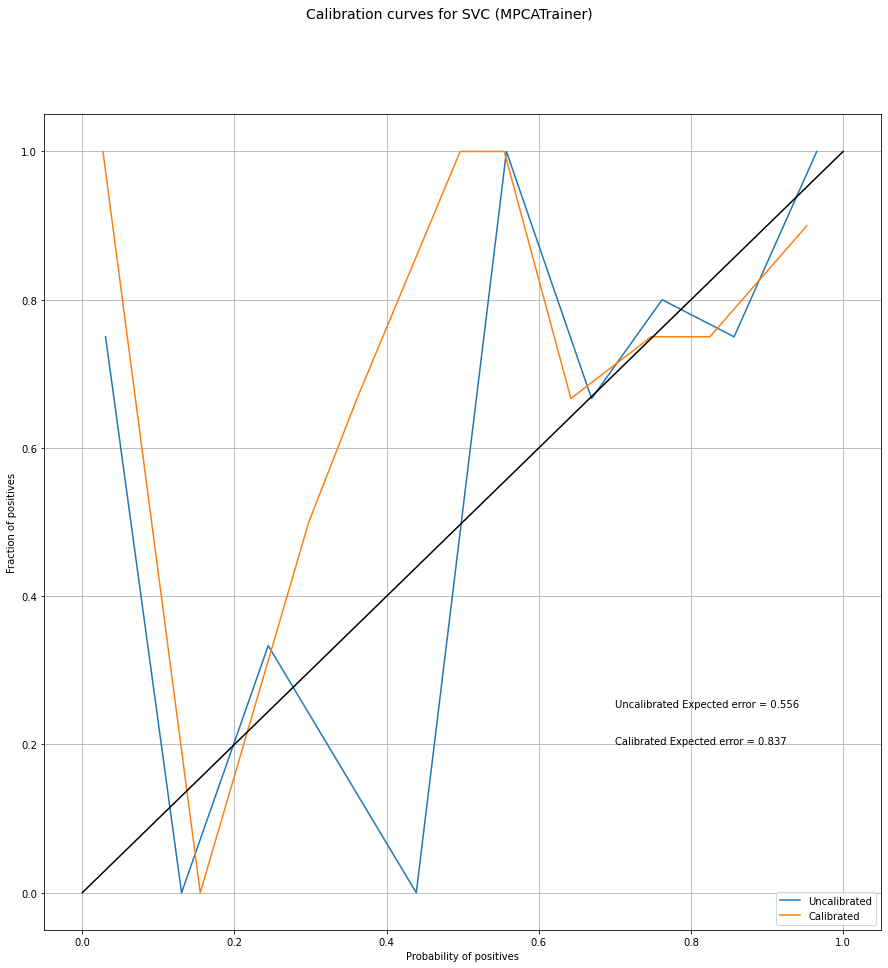

In [87]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(prob_pred_uncalb, prob_true_uncalb, label="Uncalibrated")
plt.plot(prob_pred_calb, prob_true_calb, label="Calibrated")
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
plt.grid()
ax.set_xlabel("Probability of positives")
ax.set_ylabel("Fraction of positives")
ax.legend()
plt.text(0.7,0.25, f"Uncalibrated Expected error = {ese_uncalb:.3f}")
plt.text(0.7,0.2, f"Calibrated Expected error = {ese_calb:.3f}")
fig.suptitle("Calibration curves for SVC (MPCATrainer)", fontsize=14)
fig.savefig("Calibrated vs uncalibrated", format='jpg')

In [88]:
calibrated_trainer.x_transformed.shape

(36, 378)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [90]:
expected_errors = []
for i in range(1, 1001, 10):
    trainer = MPCATrainer(classifier='svc', n_features=i)
    trainer.fit(X_train, y_train)
    y_probs = trainer.predict_proba(X_test)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)
    ese = platt.expected_error(prob_true, prob_pred, y_probs)
    
    expected_errors.append(ese)
    

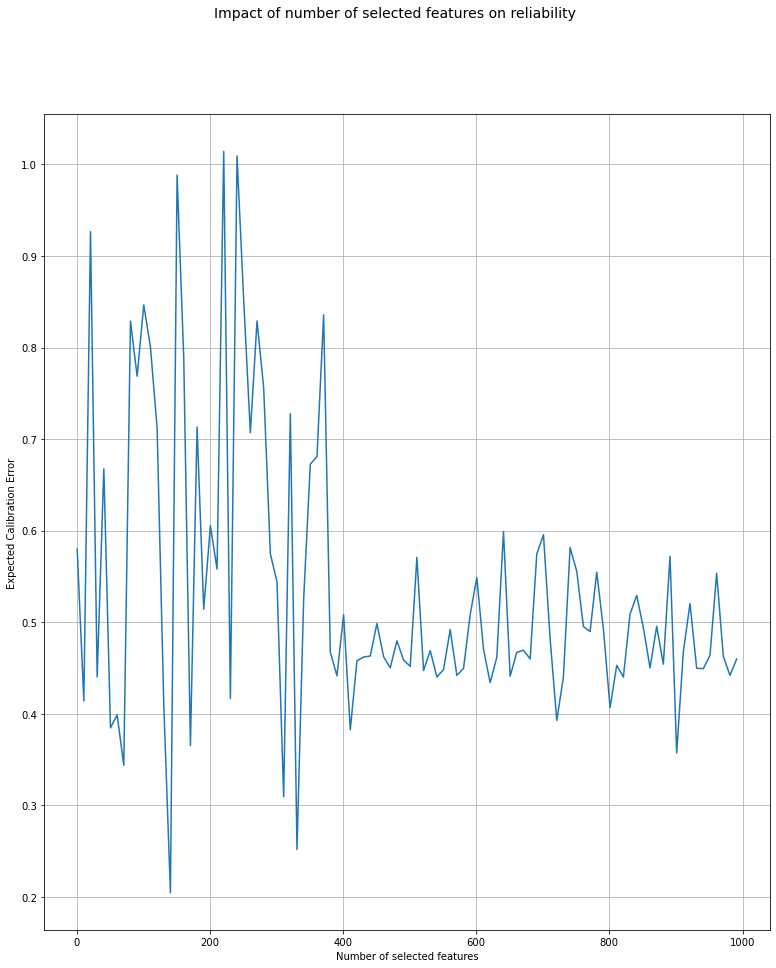

In [91]:
domain = range(1, 1001, 10)
fig, ax = plt.subplots(figsize=(13,15))
plt.plot(domain, expected_errors)
ax.grid()
ax.set_xlabel("Number of selected features")
ax.set_ylabel("Expected Calibration Error")
fig.suptitle("Impact of number of selected features on reliability", fontsize=14)
plt.savefig("impact1", format="jpg")

In [92]:
index = expected_errors.index(min(expected_errors))

In [93]:
index

14

In [94]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [95]:
expected_errors = []
for i in range(1, 1001, 10):
    trainer = MPCATrainer(classifier='svc', n_features=i)
    trainer.fit(X_train, y_train)
    y_probs = trainer.predict_proba(X_test)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)
    ese = platt.expected_error(prob_true, prob_pred, y_probs)
    
    expected_errors.append(ese)

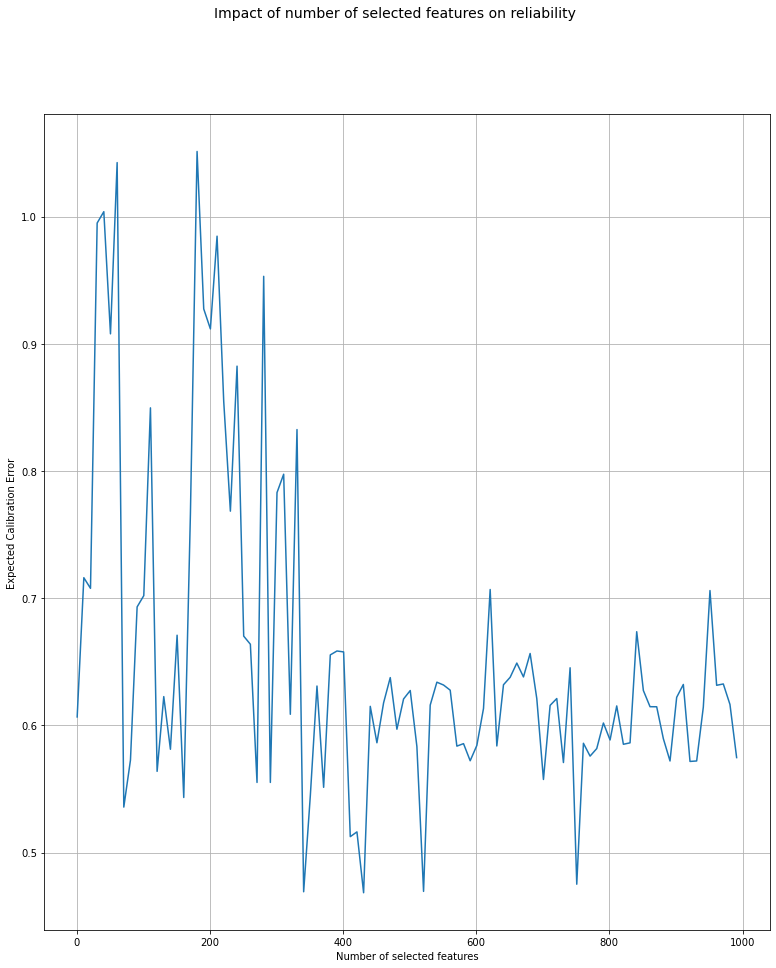

In [96]:
domain = range(1, 1001, 10)
fig, ax = plt.subplots(figsize=(13,15))
plt.plot(domain, expected_errors)
ax.grid()
ax.set_xlabel("Number of selected features")
ax.set_ylabel("Expected Calibration Error")
fig.suptitle("Impact of number of selected features on reliability", fontsize=14)
plt.savefig("impact2", format="jpg")

In [97]:
index = expected_errors.index(min(expected_errors))

In [98]:
index

43

In [99]:
y

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1])

In [100]:
import seaborn as sns
from collections import Counter

In [101]:
count = Counter(y)
count

Counter({0: 62, 1: 117})

<AxesSubplot:ylabel='Count'>

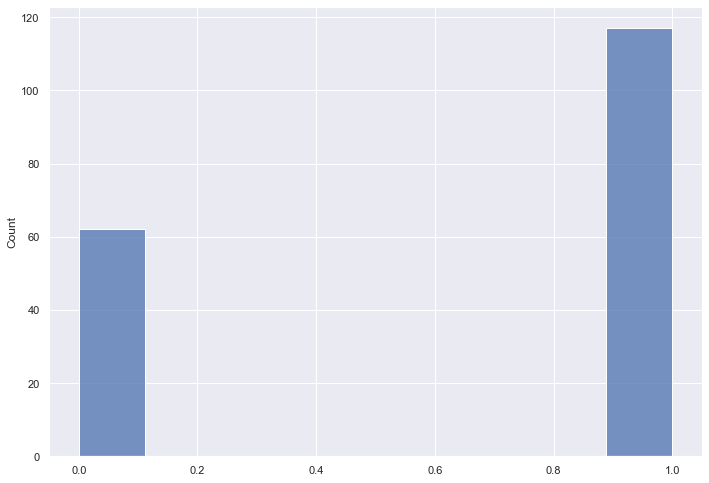

In [102]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(y)

In [103]:
# imbalanced dataset, claimed also due to the poor performance of algorithm on classification of 0 class data

In [104]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)


In [105]:
uncalibrated_trainer = MPCATrainer(classifier='svc', n_features=300)
calibrated_trainer = MPCATrainer(classifier='svc', n_features=300)
calibrated_trainer.clf = CalibratedClassifierCV(calibrated_trainer.clf, cv=10, method='sigmoid')

In [106]:
uncalibrated_trainer.fit(X_train, y_train)
calibrated_trainer.fit(X_train, y_train)

In [107]:
y_hat_uncalb = uncalibrated_trainer.predict(X_test)
y_hat_calb = calibrated_trainer.predict(X_test)

In [108]:
y_uncalb_probs = uncalibrated_trainer.predict_proba(X_test)
y_calb_probs = calibrated_trainer.predict_proba(X_test)

In [109]:
y_probs_uncalb = uncalibrated_trainer.predict_proba(X_test)[:, 1]
y_probs_calb = calibrated_trainer.predict_proba(X_test)[:, 1]

In [110]:
print(classification_report(y_test, y_hat_uncalb))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.92      0.89      0.91        27

    accuracy                           0.86        36
   macro avg       0.81      0.83      0.82        36
weighted avg       0.87      0.86      0.86        36



In [111]:
print(classification_report(y_test, y_hat_calb))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.92      0.89      0.91        27

    accuracy                           0.86        36
   macro avg       0.81      0.83      0.82        36
weighted avg       0.87      0.86      0.86        36



In [112]:
y_hat_uncalb

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [113]:
y_hat_calb

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

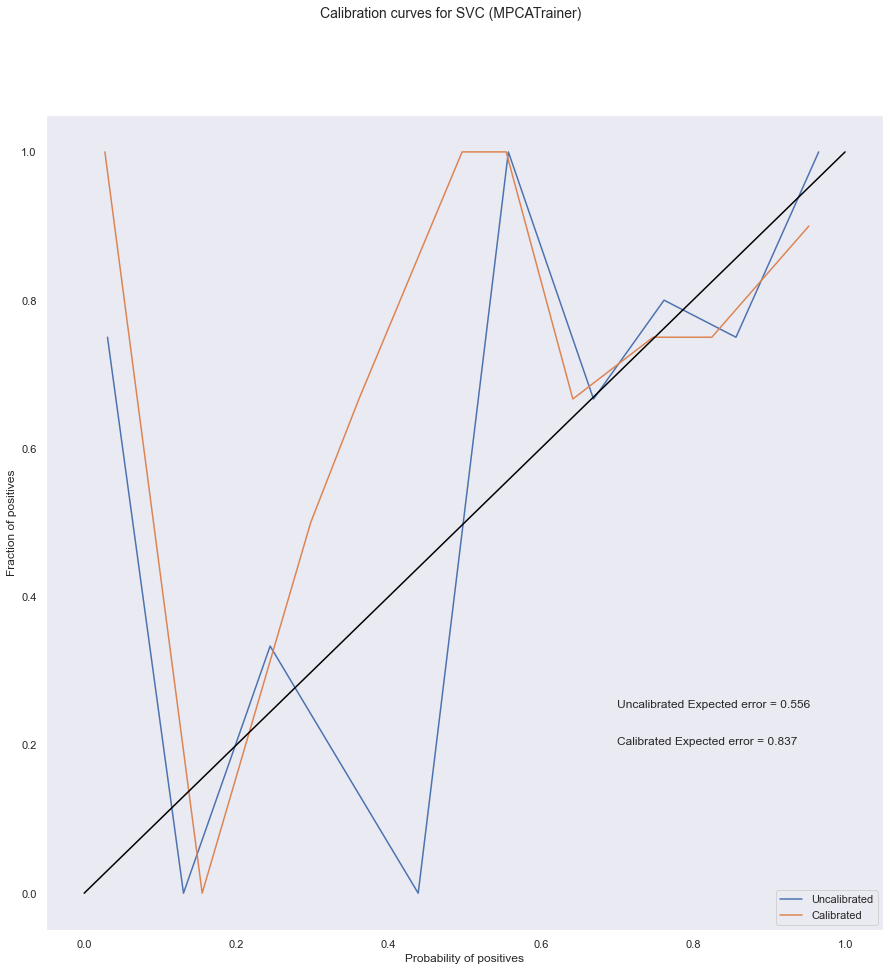

In [114]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(prob_pred_uncalb, prob_true_uncalb, label="Uncalibrated")
plt.plot(prob_pred_calb, prob_true_calb, label="Calibrated")
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
plt.grid()
ax.set_xlabel("Probability of positives")
ax.set_ylabel("Fraction of positives")
ax.legend()
plt.text(0.7,0.25, f"Uncalibrated Expected error = {ese_uncalb:.3f}")
plt.text(0.7,0.2, f"Calibrated Expected error = {ese_calb:.3f}")
fig.suptitle("Calibration curves for SVC (MPCATrainer)", fontsize=14)
fig.savefig("Calibrated vs uncalibrated", format='jpg')

Hypothesis: Creating additional images through data augmentation of deficient class will increase the probabilistic estimation of an algorithm due to removal of the imbalanced characteristics of the dataset.


In [115]:
x.shape

(179, 20, 32, 32)

In [116]:
import torchvision.transforms as transforms
from PIL import Image
import cv2

In [117]:
!pip install albumentations
import albumentations as A

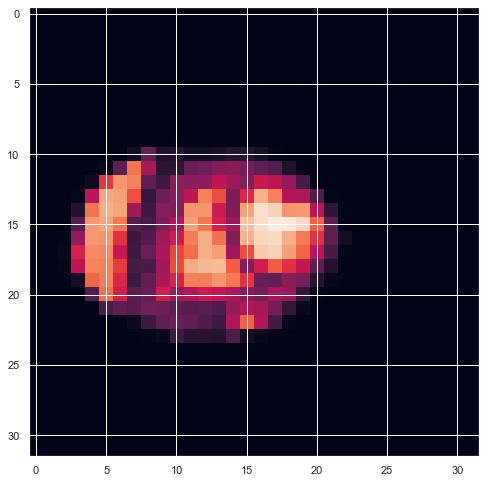

In [118]:
plt.imshow(x[0][0])
plt.show()

Now, some data augmentation is going to be implemented.


In [119]:
transform = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1)
    ]
)

In [120]:
# Creating an array of synthesised images
# Create a mechanism which would choose an index of image with label '0' so that augmented images would come from image of this class.
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [121]:
augmented_images.shape, len(labels)

((50, 20, 32, 32), 50)

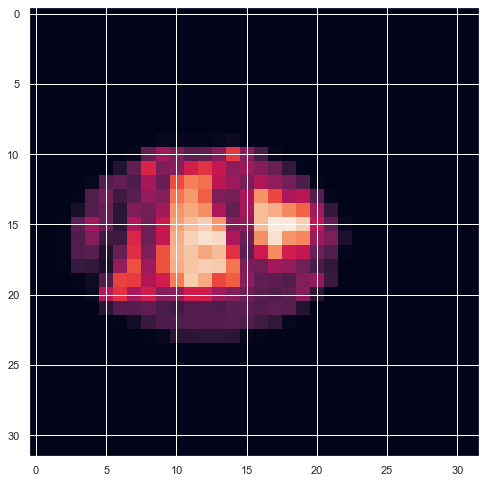

In [122]:
plt.imshow(augmented_images[9][0])
plt.show()

In [123]:
y_aug = np.array(labels)

In [124]:
y_aug

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [125]:
y_aug = y_aug.flatten()
y_aug.shape

(50,)

In [126]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(143,)

In [127]:
#for j in range(augmented_images.shape[0]):
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [128]:
X_train_aug.shape, y_train_aug.shape

((193, 20, 32, 32), (193,))

In [129]:
augmented_images.shape

(50, 20, 32, 32)

In [130]:
def expected_calibration_error(y_predicted: np.ndarray, y_probs: np.ndarray, y_test: np.ndarray, n_bins=10) -> float:
    n = y_test.shape[0]
    
    if y_test.ndim > 1:
        y_test = np.argmax(y_test)
    y_pred_idx = np.argmax(y_predicted)
    acc = np.zeros(n_bins) 
    conf = np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    
    for m in range(n_bins):
        a = m / n_bins
        b = (m+1) / n_bins
        for i in range(n):
            if y_predicted[i] > a and y_predicted[i] <= b:
                Bm[m] += 1
                if y_predicted[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += y_probs[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    
    epsilon = 0
    for m in range(n_bins):
        epsilon += Bm[m] * np.abs((acc[m] - conf[m]))
    return epsilon / np.sum(Bm[m])    
   
    

In [131]:
uncalibrated_report = classification_report(y_test, y_hat_uncalb)
print(uncalibrated_report)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.92      0.89      0.91        27

    accuracy                           0.86        36
   macro avg       0.81      0.83      0.82        36
weighted avg       0.87      0.86      0.86        36



In [132]:
calibrated_report = classification_report(y_test, y_hat_calb)
print(calibrated_report)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.92      0.89      0.91        27

    accuracy                           0.86        36
   macro avg       0.81      0.83      0.82        36
weighted avg       0.87      0.86      0.86        36



In [133]:
expected_calibration_error(y_hat_calb, y_calb_probs[:, 1], y_test), expected_calibration_error(y_hat_calb, y_uncalb_probs[:, 1], y_test)

(0.0824583836366295, 0.0921922954455765)

This implementation of expected calibration error is much better and accurate. Although there are still cases of data shuffling data calibation will not help (or even make the error large than for uncalibrated trainer. However, it's still worth doing that.

In [134]:
brier_score_loss(y_test, y_calb_probs[:, 0]), brier_score_loss(y_test, y_uncalb_probs[:, 0])

(0.6211875831803453, 0.6038932726985808)

In [135]:
brier_score_loss(y_test, y_calb_probs[:, 1]), brier_score_loss(y_test, y_uncalb_probs[:, 1])

(0.10709892751390289, 0.10717906320279466)

In [136]:
uncalibrated_trainer = MPCATrainer(classifier='svc', n_features=300)
calibrated_trainer = MPCATrainer(classifier='svc', n_features=300)
calibrated_trainer.clf = CalibratedClassifierCV(calibrated_trainer.clf, cv=10, method='sigmoid')

In [137]:
uncalibrated_trainer.fit(X_train_aug, y_train_aug)
calibrated_trainer.fit(X_train_aug, y_train_aug)

In [138]:
y_hat_uncalb = uncalibrated_trainer.predict(X_test)
y_hat_calb = calibrated_trainer.predict(X_test)

In [139]:
y_uncalb_probs = uncalibrated_trainer.predict_proba(X_test)
y_calb_probs = calibrated_trainer.predict_proba(X_test)

In [140]:
print(classification_report(y_test, y_hat_calb))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.88      0.78      0.82        27

    accuracy                           0.75        36
   macro avg       0.69      0.72      0.70        36
weighted avg       0.78      0.75      0.76        36



In [141]:
print(classification_report(y_test, y_hat_uncalb))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.88      0.78      0.82        27

    accuracy                           0.75        36
   macro avg       0.69      0.72      0.70        36
weighted avg       0.78      0.75      0.76        36



In [142]:
expected_calibration_error(y_hat_calb, y_calb_probs[:, 1], y_test), expected_calibration_error(y_hat_calb, y_uncalb_probs[:, 1], y_test)

(0.12195552873296789, 0.10239621926693321)

In [143]:
brier_score_loss(y_test, y_calb_probs[:, 0]), brier_score_loss(y_test, y_uncalb_probs[:, 0])

(0.48525631842221667, 0.5088420616551278)

In [144]:
brier_score_loss(y_test, y_calb_probs[:, 1]), brier_score_loss(y_test, y_uncalb_probs[:, 1])

(0.16228723061216838, 0.1621072995681011)

In [145]:
expected_errors = []
accuracies = []
for i in range(1, 1001, 10):
    trainer = MPCATrainer(classifier='svc', n_features=i)
    trainer.fit(X_train, y_train)
    y_hat = trainer.predict(X_test)
    y_probs = trainer.predict_proba(X_test)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, normalize=True)
    ese = expected_calibration_error(y_hat, y_probs, y_test)
    acc = balanced_accuracy_score(y_test, y_hat)
    
    accuracies.append(acc)
    expected_errors.append(ese)

Text(0.5, 0.98, 'Impact of number of selected features on reliability')

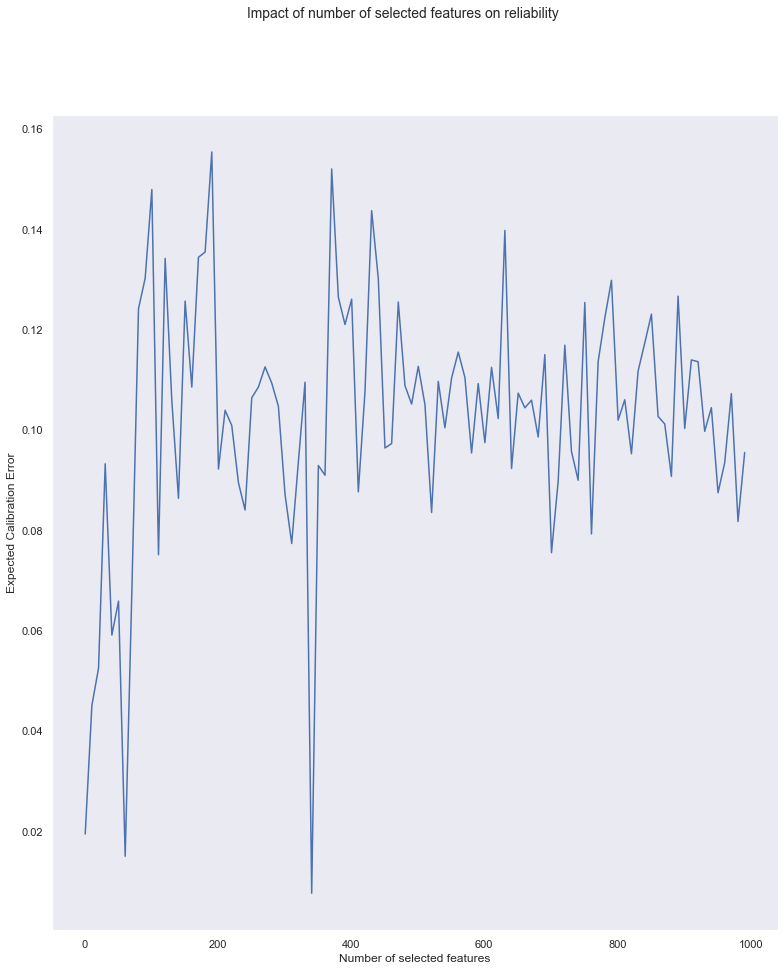

In [146]:
domain = range(1, 1001, 10)
fig, ax = plt.subplots(figsize=(13,15))
plt.plot(domain, expected_errors)
ax.grid()
ax.set_xlabel("Number of selected features")
ax.set_ylabel("Expected Calibration Error")
fig.suptitle("Impact of number of selected features on reliability", fontsize=14)

Text(0.5, 0.98, 'Impact of number of selected features on reliability')

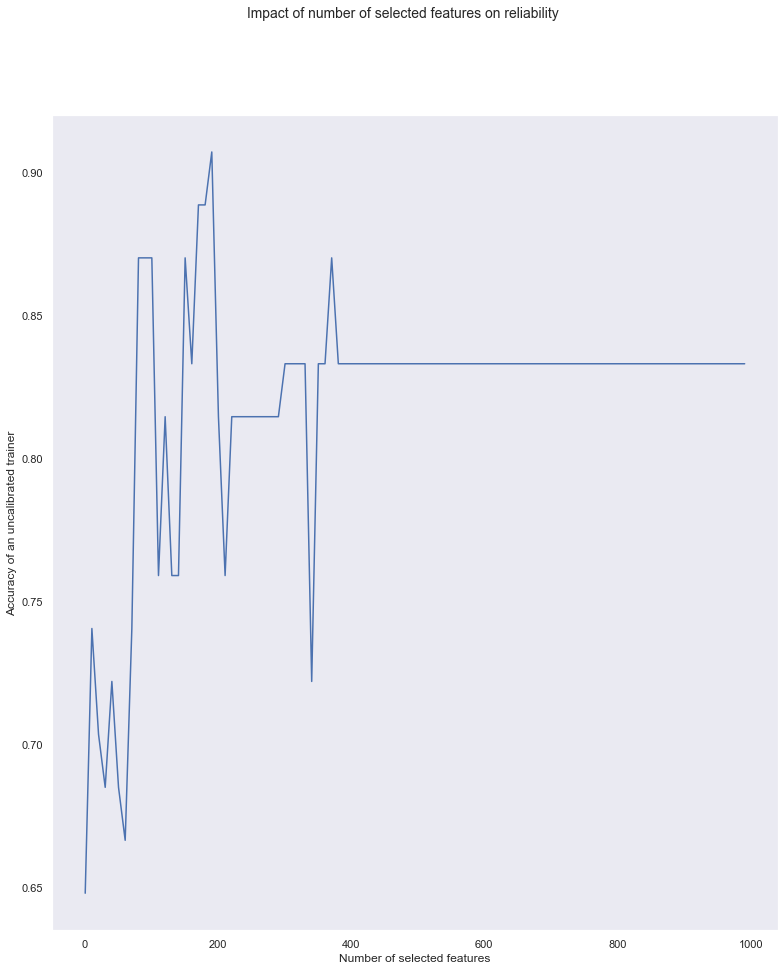

In [147]:
domain = range(1, 1001, 10)
fig, ax = plt.subplots(figsize=(13,15))
plt.plot(domain, accuracies)
ax.grid()
ax.set_xlabel("Number of selected features")
ax.set_ylabel("Accuracy of an uncalibrated trainer")
fig.suptitle("Impact of number of selected features on reliability", fontsize=14)

In [148]:
expected_errors[17], accuracies[17]

(0.13443844196929478, 0.8888888888888888)

In [149]:
accuracies

[0.6481481481481481,
 0.7407407407407407,
 0.7037037037037037,
 0.6851851851851851,
 0.7222222222222222,
 0.6851851851851851,
 0.6666666666666667,
 0.7407407407407407,
 0.8703703703703703,
 0.8703703703703703,
 0.8703703703703703,
 0.7592592592592593,
 0.8148148148148149,
 0.7592592592592593,
 0.7592592592592593,
 0.8703703703703703,
 0.8333333333333333,
 0.8888888888888888,
 0.8888888888888888,
 0.9074074074074074,
 0.8148148148148149,
 0.7592592592592593,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8148148148148149,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.7222222222222222,
 0.8333333333333333,
 0.8333333333333333,
 0.8703703703703703,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333333333,
 0.8333333333